# PHYS 481 Assignment 8

## Authors: 
Siegfried Peschke (30032136) \\
Matthew Bouchard (30003689) \\
Chris Godek (30030527)

### Importing Necessary Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 1:
**Find the lowest energy state of the Ising model numerically:**
Consider Ising spins on a ring (i.e. a line with periodic boundary conditions), for some $N$ around 30 to 50 (your choice). Choose a low dimensionless temperature of $\tilde{T}=1$. For dimensionless magnetic fields in the range $-2\leq\tilde{B}\leq 2$, use Metropolis sampling to find the ground state energy and compare with the theoretical value. Approximately how many (directed) random samples are required to find the true ground state? How do the results depend on the (dimensionless) magnetic field? What happens if you increase the (dimensionless) temperature? Note that for as few as 30 spins there are $2^{30}\approx 10^9$ different spin configurations, which would take waaaaay too long to check without some kind of optimizing random algorithm.

To start, it is imperitive that we generate a random ising model. A 1 dimensional Ising model or chain can be modelled computationally by a simple array, which which will be comprised of randomly sampled spins. The spins in our situatuon can either be up (+1) or down (-1). We will construct the lattice by randomly picking if a given spin is up or down (with an equal probability for both). The size of the lattice can be specified by the user (N), however, for the purpose of this assignment we will set N=50.

In [ ]:
def gen_ising(N):

  """
  -- General Description --

  This function generates a N size one-dimensional array of 1's and -1's to represent
  spin alignments in the Ising model.

  -- Arguments --

  N = The size of the array

  """
  return np.random.choice([1,-1], size=N)

In [ ]:
#Test if gen_ising works - note that we have just created a length 20 array as a representation (50 is very large)

test_ising = gen_ising(20)
print(test_ising)

[ 1 -1  1  1 -1 -1  1  1  1 -1  1  1  1  1  1 -1  1 -1  1  1]


Now that we have generated a random Ising chain our next task is to flip a random spin within the lattice. We want to perform this operation because it is a critical part of Metropolis sampling. This can be done via the function below:

In [ ]:
def single_flip(ising, pr):

  """

  -- General Description --

  This function flips one of the spin states in the one-dimensional array of the Ising model.

  -- Arguments --

  ising = The ising chain for which you wish to flip a random spin
  pr = Specifies if the user would like to have a print statement of the flipped index
       True = Yes, False = No

  """

  loc = np.random.randint(0,len(ising))

  # Flipping a randomly chosen spin
  new_ising = ising.copy()
  new_ising[loc] = -1*ising[loc]

  if pr == True: # Printing the index at which the flip occured
    print('Spin flip occurs at index:', loc)

  return new_ising # Returning the newly flipped ising model

In [ ]:
#Test if single_flip works

print(test_ising)
print(single_flip(test_ising, True))

[ 1 -1  1  1 -1 -1  1  1  1 -1  1  1  1  1  1 -1  1 -1  1  1]
Spin flip occurs at index: 8
[ 1 -1  1  1 -1 -1  1  1 -1 -1  1  1  1  1  1 -1  1 -1  1  1]


As we can see, a spin was flipped at the third index. So this function works as expected! Next, we wish to perform the metropolis algorithm. This works in the following manner:

1. Flip a spin randomly within the Ising model

2. If the flipped or "new" arrangment has a lower energy we take that as the "new" ising chain. The energy of the system is defined by the following expression:

$$\tilde{H}=-\sum_{\langle ij\rangle}S_iS_j+\tilde{B}\sum_iS_i,$$

3. If the energy is not lower we will randomly choose if the newly flipped chain is accepted or not, this will be based upon the following probabilities:

$${\mathcal P}=\frac{p(\alpha_{k+1})}{p(\alpha_k)}=\exp\left(-\frac{\Delta E}{k_BT}\right)\leq 1,$$

4. Continue to flip and sample the energies over a user specified interval (maybe 80,000 random flips) and during that time we want to determie what the lowest possible energy state is.

After completion of the metropolis algorithm we should have a fairly accurate idea as to the lowest energy for a given ising chain of length $N$ for a given $\tilde{B}$ and $T$. As such, let us start by defining a function that will calculate the energy of the system:

In [ ]:
def calc_energy(B, ising):

  """
  -- Generel Description --

  This function calculates the internal energy of a given Ising model arrangement with respect
  to a specified magnetic field strength.

  -- Arguments --

  B = The magnetic field in which the ising chain has been placed
  Ising = The ising chain for which you would like to calculate the systemic energy
  """

  SiSj = []

  for i in range(len(ising)):
    if i != (len(ising)-1):
      SiSj.append(ising[i]*ising[i+1])
    else:
      SiSj.append(ising[i]*ising[0])

  return B*sum(ising) - sum(SiSj)

In [ ]:
# Testing that we return the expected energy

calc_energy(3,test_ising)

24

Our next step is to determine if we will accept a flipped ising chain or not (as described in step 3 above). This can be done by the following function:

In [ ]:
def calc_switch(T, B, m0, m1, y):

  """

  -- General Description --

  This function assess two different Ising model arrangements, compares their internal energy,
  and determines based on probabilities which Ising model to 'keep'.

  -- Arguments --

  T = Temperature of the Ising chain
  B = The magnetic field from which the Ising chain was placed in


  """
  E0 = calc_energy(B, m0)
  E1 = calc_energy(B, m1)
  P = np.exp(-(E1-E0)/T)

  if P > 1:
    return m1, E1, y+1
  else:
    q = np.random.random()
    if q < P:
      return m1, E1, y+1
    else: # Don't accept spin flip
      return m0, E0, y+1

And finally, we can perform this over a specified number of iterations in an attempt to determine the lowest energy state of an Ising chain of length N=50 that has been placed in a $\tilde{B}$ at some temperature T. The following function does this for us:

In [ ]:
def find_ground_state(T, B, N, tol, P_num):

  """

  -- General Description --
  This function generates a random arrangement for the Ising model, then performs spin flips,
  assess whether a spin flip generates a lower energy model and whether or not to keep the spin
  flipped model, then repeats this until for "tol" iterations in the hope the ground state was reached.
  
  It also keeps track of statistics in order to assess how the ground states are effected by varying temperature.

  """

  m0 = gen_ising(N)
  E = calc_energy(B, m0)
  E_list = []
  x = 0
  y = 0

  while x < tol:
    m1 = single_flip(m0, False)
    m0, E0, y = calc_switch(T, B, m0, m1, y)
    E_list.append(E0)

    if E0 < E:
      best_m = m0.copy() # Saving the best (lowest NRG) ising model arangement
      E = E0 # Setting this to the lowest value
      best_y = y
      x = 0 # Resetting the tolerance if a new value is found
      
    x += 1

  if P_num == 1:
    return best_m, E, best_y

  elif P_num == 2:
    return E_list, m0

  else:
    print('Error, problem number not specified')
    return

And we can compare our results with theoretical values through the use of the following equation:

In [ ]:
def theoretical_low_energy(B, N):

  """

  -- General Description --

  This function calculates the lowest theoretical energy of an Ising chain of 
  size N placed in a magnetic field B.

  -- Arguments --

  B = The magnetic field that the Ising chain has been placed in
  N = The size of the Ising chain

  """

  return -N - abs(B*N)

And finally, we can use all our functions to determine the lowest energy level and compare it with expected values:

In [ ]:
N = 50
tol = 8000
for T in range(1,6,2):
  for B in range(-2,3):
    best_m, E, best_y = find_ground_state(T, B, N, tol, 1)
    print('The lowest energy state of the Ising model of N =', N, 'at T =', T,
          'and B =', B, 'is \n U =', E, 'which took', best_y, 'spin flips to reach.')
    print('The theoretical lowest energy is U =',
          theoretical_low_energy(B, N), '\n')
  print('-----------------------------------------------------------------------')


The lowest energy state of the Ising model of N = 50 at T = 1 and B = -2 is 
 U = -150 which took 382 spin flips to reach.
The theoretical lowest energy is U = -150 

The lowest energy state of the Ising model of N = 50 at T = 1 and B = -1 is 
 U = -100 which took 196 spin flips to reach.
The theoretical lowest energy is U = -100 

The lowest energy state of the Ising model of N = 50 at T = 1 and B = 0 is 
 U = -46 which took 5238 spin flips to reach.
The theoretical lowest energy is U = -50 

The lowest energy state of the Ising model of N = 50 at T = 1 and B = 1 is 
 U = -100 which took 352 spin flips to reach.
The theoretical lowest energy is U = -100 

The lowest energy state of the Ising model of N = 50 at T = 1 and B = 2 is 
 U = -150 which took 250 spin flips to reach.
The theoretical lowest energy is U = -150 

-----------------------------------------------------------------------
The lowest energy state of the Ising model of N = 50 at T = 3 and B = -2 is 
 U = -150 which took

We notice when $B = 0$ the experimental method of determining the ground state does not quite achieve the correct value for the lowest internal energy within the limit of iterations. (Occasionally, depending on the randomly generated initial arangment of spins the algorithm does find the correct ground state) In the case of $B = 0$, we only have the Ising interaction between spins, which is lowest energy when neighbouring spins align. Therefore the lowest energy state will be either all spin down or all spin up. The problem our algorithm has when trying to find the ground state is which to decide on, spin up or spin down? It's completely random and both are ground states, thus it takes many more iterations to reach one of these two states. In all other cases of $B$, the magnetic field dictates which way to align, all spin down or all spin up. For other values of $B$ we find the experimental method of determining the ground state effectively finds the correct lowest energy state. As the magnitude of $B$ increases, the number of spin flips required to reach the ground state decreases.

Experimenting with increased temperature values we found it takes more spin flips to find the ground state and it becomes less likely the algorithm finds the lowest energy state within the limit of iterations.

# Problem 2:
**Obtain the mean energy and entropy of the Ising model as a function of temperature:**
Use the method developed above to obtain the mean energy and entropy of the one-dimensional Ising model as a function of temperature, for various choices of magnetic field (including zero). Plot the results, and comment on their behaviour; compare and contrast with the results for the Pauli paramagnet.

In order for us to calculate the entropy of an Ising chain we can make use of the shannon entropy, which states:

$$
S = -N\sum p_i \ln(p_i)
$$

As such, allow us to define a function that will determine the shannon entropy:

In [ ]:
def calc_entropy(vals):

  """

  -- General Description --

  This function calculates the entropy of an Ising model arrangement of spins.

  -- Arguments --

  vals = The ising chain for which we wish to calculate the shannon entropy

  """

  entropy = 0
  N = len(vals)
  u_vals, occur = np.unique(vals, return_counts = True)

  for n in occur:
    p_i = n/N
    entropy -= p_i*np.log(p_i)
    
  return N*entropy

In [ ]:
E_list, m = find_ground_state(20, 1, N, tol, 2)
print(m)

[-1  1  1 -1 -1 -1 -1 -1  1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1
  1 -1  1  1  1  1  1  1  1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1  1  1 -1  1
  1 -1]


And finally, we can calculate the mean energy of a given ising chain by averaging the second half of the total sampled energy levels (to reduce computation time whilst still inferring the general trend) and we will simply calculate the entropy of the final returned ising chain (this is to save computation time and was recomended by Dr.Feder). Thereby:

In [ ]:
N = 50
tol = 5000
master_mean_list = []
master_entropy_list = []

for B in range(-2,3):
  mean_E_list = []
  entropy_list = []

  for T in range(1,100):
    E_list, m = find_ground_state(T, B, N, tol, 2)
    mean_E_list.append(np.mean(E_list[len(E_list)//2:]))
    entropy_list.append(calc_entropy(m))
    
  master_entropy_list.append(entropy_list)
  master_mean_list.append(mean_E_list)

Finally, we can plot the internal energy as a function of temperature:

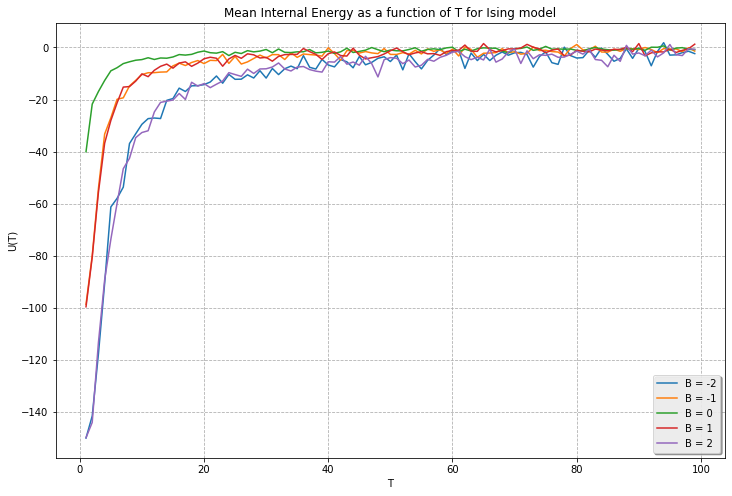

In [ ]:
#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('T')
plt.ylabel('U(T)')
plt.title('Mean Internal Energy as a function of T for Ising model')
plt.grid(linestyle='dashed')

#Plot the Function
i = -2
for E_list in master_mean_list:
  label_name = 'B = ' + str(i)
  plt.plot(list(range(1,100)), E_list, label = label_name)
  i += 1

#Legend Settings
legend = plt.legend(loc = 4, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

This plot is expected. At extremely low temperatures the spin are highly organized, thereby they have a higher propensity to all be in the same energy state. As temperature increases we see the arrival of disorder and a corresponding increase in the mean internal energy. This is because as the temperature increases, the probability of keeping a favourable spin flip decreases and as such the system goes roughly to $\frac{1}{2}$ spin up and the other $\frac{1}{2}$ spin down.

Finally, allow us to plot the entropy as a function of temperature:

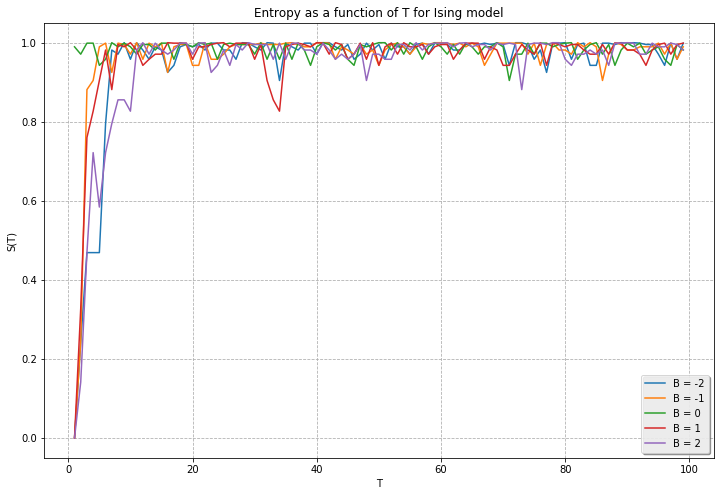

In [ ]:
#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('T')
plt.ylabel('S(T)')
plt.title('Entropy as a function of T for Ising model')
plt.grid(linestyle='dashed')

#Plot the Function
i = -2
for entrop_list in master_entropy_list:
  label_name = 'B = ' + str(i)
  plt.plot(list(range(1,100)), entrop_list, label = label_name)
  i += 1

#Legend Settings
legend = plt.legend(loc = 4, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

And as expected, the system becomes more disorganized as we increase the temperature of the Ising model - which is represented by a higher entropy value. We reach a maximum value of 1 in this plot, which is indicative of the following:

$$
S = -(-0.5 \log_2(0.5) - 0.5 \log_2(0.5) ) = - (-0.5-0.5) = 1
$$

Thereby, it indicates that for high temperatures we would theoretically see the Ising chain be 50% spin-up and 50% spin-down. The reason that we see deviations from expected is most likely because we are not sampling over all our possible configurations, but rather only calculating the final Ising chain (in the hopes of reducing computation time).